# Data Pre-processing & Feature Selection

In [ ]:
###########################################################################
#
#  Copyright 2021 Google Inc.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
# This solution, including any related sample code or data, is made available 
# on an “as is,” “as available,” and “with all faults” basis, solely for 
# illustrative purposes, and without warranty or representation of any kind. 
# This solution is experimental, unsupported and provided solely for your 
# convenience. Your use of it is subject to your agreements with Google, as 
# applicable, and may constitute a beta feature as defined under those 
# agreements.  To the extent that you make any data available to Google in 
# connection with your use of the solution, you represent and warrant that you 
# have all necessary and appropriate rights, consents and permissions to permit 
# Google to use and process that data.  By using any portion of this solution, 
# you acknowledge, assume and accept all risks, known and unknown, associated 
# with its usage, including with respect to your deployment of any portion of 
# this solution in your systems, or usage in connection with your business, 
# if at all.
###########################################################################

## 0) Dependencies

In [ ]:
import requests
import io
import os
import datetime
import logging

# Google credentials authentication libraries
from google.colab import auth

!pip install --upgrade -q gspread 
import gspread

from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

# data processing libraries
import numpy as np
from numpy.core.numeric import NaN
import pandas as pd


from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, RFE, RFECV
from sklearn.feature_selection import f_classif, f_regression, chi2
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier

# modeling and metrics
from scipy.optimize import least_squares
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm


import itertools
from scipy.stats.stats import pearsonr

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# BigQuery Magics
'''
BigQuery magics are used to run BigQuery SQL queries in a python environment.
These queries can also be run in the BigQuery UI
'''

from google.cloud import bigquery
from google.cloud.bigquery import magics
magics.context.project = '' #update your project name 
client = bigquery.Client(project=magics.context.project)
%load_ext google.cloud.bigquery
bigquery.USE_LEGACY_SQL = False


The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


## 1) Import dataset

In [ ]:
%%bigquery df
SELECT *
FROM `.RBA_demo.SAMPLE_DATA`; #update with project name

In [ ]:
df.head()

,geo,date,y1,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46
0,Northeast,2017-09-04 00:00:00+00:00,2258,48295480,1789,14961,21321,2934,27861,23083,1.20302,11457,9726,3276,3263,7659,2170,7127,433,43,44079352,5485207,4028351,16696516,8083962,6398572,608760,2837865,358841,359573,0,2501672,111255,109951,557543,14005879,1113197,1267820,0,458519,1886635,2358978,641381,7842969,3958070,0,1702231,2414536,1729212
1,Northeast,2017-09-05 00:00:00+00:00,3140,46867144,2017,19883,26379,3525,32136,32550,0.95112,13388,12898,4059,3662,9214,2500,10173,471,42,47565640,6891432,3754244,16118995,9395026,6312236,667357,3817186,376289,928160,0,2053063,114184,116139,685283,14008012,1035537,1135248,0,461112,1803811,2405801,587515,10018162,3717213,0,2236497,2788529,2568644
2,Northeast,2017-09-08 00:00:00+00:00,2253,52946853,1872,17798,23043,2807,28748,28317,0.98481,11652,11017,3233,3319,7828,2353,9568,421,84,39433266,5956677,2962264,9950959,9528970,6361696,758584,2716435,357525,862526,0,2309881,115646,107146,421895,7510168,1219954,1199804,0,326926,1462727,2295267,582325,8665153,2672611,0,1988181,2223178,1889816
3,Northeast,2017-09-09 00:00:00+00:00,1888,51527610,1800,15383,21023,3091,27638,24246,1.16516,11554,9253,3306,2986,7400,2072,7646,422,78,34986121,5118162,2602023,9165565,7659374,6107525,627391,2484630,309679,798040,0,1801605,122723,108494,403645,7578970,1283406,1514418,0,319552,1847868,1200901,488950,7422186,2386980,0,2213709,2303075,1786623
4,Northeast,2017-09-10 00:00:00+00:00,1623,51572539,2040,18561,24385,2943,30874,28190,1.11976,13852,10122,3476,3183,9850,2121,8437,433,88,38834976,5996156,2800133,10962081,7866840,6491669,593808,2594647,406079,727476,0,2142987,117797,112672,372197,8604309,1081421,1516359,0,301081,2010315,2496461,555649,7652613,2848655,0,1984963,2405399,1780011


In [ ]:
'''
Immediately remove variables that won't be used in the model. Here, includes things
like geo which is consistent across the dataset, and aggregated media such as 
total clicks across DSPs
'''
df.drop(columns = ['geo','date','x1','x2','x18','x19','x20','x21','x22','x23','x24','x25'], inplace = True)

In [ ]:
len(df.columns)

37

In [ ]:
df.describe()

,y1,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46
count,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000,607.00000
mean,2250.15321,9502.77100,21480.94563,1998.41680,24959.23394,21734.89786,1.21983,11313.50741,9823.90115,2353.00494,4147.06590,4761.00659,3276.47611,4718.88797,311.25206,14.62273,98879.23229,565270.65239,79538.84843,4397846.13674,103429.12356,103455.26359,232131.82537,10222483.63427,1251220.30807,2935893.03130,0.01647,579577.02801,629286.96211,2203550.21582,768464.30148,7349729.80890,3258401.86326,134927.09061,5758483.16804,562753.05437,526326.02636
std,461.35767,2917.87708,2305.48727,973.92067,2243.19098,4067.72694,0.29786,1355.41852,1155.54966,975.56904,702.65287,1441.56411,626.70092,1560.05009,161.98211,23.78516,115048.34158,491736.52382,330362.71054,2807112.93335,70913.71109,70656.86459,126717.52348,3042437.80485,704994.41118,2214740.24515,0.40589,272502.95446,656588.69512,479677.52536,259129.80186,2712473.38316,1615738.65995,140461.95610,4002110.54216,446515.11749,530072.46490
min,1159.00000,5669.00000,15223.00000,0.00000,18347.00000,13897.00000,0.75973,8146.00000,6488.00000,808.00000,2555.00000,2475.00000,1764.00000,2562.00000,0.00000,0.00000,0.00000,0.00000,0.00000,918921.00000,0.00000,0.00000,0.00000,3350974.00000,291854.00000,0.00000,0.00000,0.00000,0.00000,861858.00000,0.00000,2201342.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,1924.00000,7296.50000,19855.00000,1121.00000,23432.50000,18349.00000,0.98585,10240.00000,8993.00000,1475.00000,3597.50000,3554.00000,2828.50000,3575.00000,257.50000,5.00000,0.00000,236067.00000,0.00000,2149083.00000,73754.00000,72877.00000,130867.50000,8219412.00000,692688.00000,1381817.50000,0.00000,415833.50000,221757.00000,2076953.50000,636682.50000,5595286.50000,2385656.50000,0.00000,4004452.00000,291539.00000,247696.00000
50%,2227.00000,8455.00000,21373.00000,2017.00000,24824.00000,21768.00000,1.12697,11411.00000,9868.00000,2327.00000,4094.00000,4482.00000,3280.00000,4124.00000,347.00000,8.00000,51982.00000,469503.00000,51943.00000,3074997.00000,103344.00000,104647.00000,206513.00000,9669682.00000,1055786.00000,2271089.00000,0.00000,481875.00000,350079.00000,2289272.00000,769383.00000,6828403.00000,3288012.00000,113893.00000,4847731.00000,457440.00000,341713.00000
75%,2459.00000,11388.50000,23064.50000,2672.00000,26364.00000,24880.50000,1.43795,12319.00000,10598.50000,3040.00000,4609.50000,5456.50000,3734.50000,5731.50000,426.00000,14.00000,181609.50000,881088.00000,92216.00000,6533253.50000,134778.00000,137073.50000,315230.00000,11580379.00000,1725023.50000,3626790.50000,0.00000,723718.00000,893655.50000,2495785.00000,864292.50000,8298399.00000,4326991.00000,223723.50000,6381994.00000,630891.50000,550913.00000
max,3783.00000,19883.00000,28950.00000,6303.00000,32266.00000,32672.00000,2.16112,15519.00000,13519.00000,6603.00000,6574.00000,9850.00000,5073.00000,10255.00000,819.00000,309.00000,470583.00000,3141029.00000,7849832.00000,12091933.00000,515625.00000,500368.00000,730073.00000,21377465.00000,3671156.00000,9882099.00000,10.00000,1518639.00000,3147112.00000,3174199.00000,3772181.00000,18408280.00000,12486028.00000,876548.00000,22992582.00000,2898016.00000,3341587.00000


## 2) Data Cleaning

### 2.1) Drop or impute missing data

In [ ]:
'''
Determine number of missing values (% of total column) and sort by highest to lowest
'''
missing_values = 100*df.isnull().sum()/len(df)
missing_values.sort_values(ascending = False)

x46   0.00000
x27   0.00000
x17   0.00000
x16   0.00000
x15   0.00000
x14   0.00000
x13   0.00000
x12   0.00000
x11   0.00000
x10   0.00000
x9    0.00000
x8    0.00000
x7    0.00000
x6    0.00000
x5    0.00000
x4    0.00000
x3    0.00000
x26   0.00000
x28   0.00000
x45   0.00000
x29   0.00000
x44   0.00000
x43   0.00000
x42   0.00000
x41   0.00000
x40   0.00000
x39   0.00000
x38   0.00000
x37   0.00000
x36   0.00000
x35   0.00000
x34   0.00000
x33   0.00000
x32   0.00000
x31   0.00000
x30   0.00000
y1    0.00000
dtype: float64

In [ ]:
'''
Set a threshold for % of missing values. If the % of missing data exceeds this
threshold, the column will be dropped.

Removing variables with a high % of missing data is important so as not to include
uninformative features in the model.
'''

remove_missing_vals = "Yes"
missing_value_threshold = 50

missing_value_threshold_cols = []

if remove_missing_vals == "Yes":
  for i in missing_values[missing_values >= missing_value_threshold].index:
    missing_value_threshold_cols += i
    df.drop(columns = i, inplace = True)
else:
  print('No columns dropped')

print('Remaining columns:',df.columns)

Remaining columns: Index(['y1', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12',
       'x13', 'x14', 'x15', 'x16', 'x17', 'x26', 'x27', 'x28', 'x29', 'x30',
       'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40',
       'x41', 'x42', 'x43', 'x44', 'x45', 'x46'],
      dtype='object')


In [ ]:
# Imputation Method: Mean value, Median Value, Zero
imputation_method = 'Zero'

In [ ]:
if imputation_method == 'mean value':
  df.fillna(df.mean(), inplace = True)
elif imputation_method == 'median value':
  df.fillna(df.median(), inplace = True)
elif imputation_method == 'Zero':
  df.fillna(0, inplace = True)
else:
  df.fillna(0, inplace = True)


## 3) Define Y (KPI column) and create initial feature set

In [ ]:
df.head()

,y1,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46
0,2258,14961,21321,2934,27861,23083,1.20302,11457,9726,3276,3263,7659,2170,7127,433,43,358841,359573,0,2501672,111255,109951,557543,14005879,1113197,1267820,0,458519,1886635,2358978,641381,7842969,3958070,0,1702231,2414536,1729212
1,3140,19883,26379,3525,32136,32550,0.95112,13388,12898,4059,3662,9214,2500,10173,471,42,376289,928160,0,2053063,114184,116139,685283,14008012,1035537,1135248,0,461112,1803811,2405801,587515,10018162,3717213,0,2236497,2788529,2568644
2,2253,17798,23043,2807,28748,28317,0.98481,11652,11017,3233,3319,7828,2353,9568,421,84,357525,862526,0,2309881,115646,107146,421895,7510168,1219954,1199804,0,326926,1462727,2295267,582325,8665153,2672611,0,1988181,2223178,1889816
3,1888,15383,21023,3091,27638,24246,1.16516,11554,9253,3306,2986,7400,2072,7646,422,78,309679,798040,0,1801605,122723,108494,403645,7578970,1283406,1514418,0,319552,1847868,1200901,488950,7422186,2386980,0,2213709,2303075,1786623
4,1623,18561,24385,2943,30874,28190,1.11976,13852,10122,3476,3183,9850,2121,8437,433,88,406079,727476,0,2142987,117797,112672,372197,8604309,1081421,1516359,0,301081,2010315,2496461,555649,7652613,2848655,0,1984963,2405399,1780011


In [ ]:
#Input column names for date (ex: "day") and Y (ex: "new_accounts" or "sales") 

date_col = "date" #{type: "string"}
kpi_col = "y1" #{type: "string"}


In [ ]:
featureset_df = df[df.columns[df.columns != kpi_col]]
featureset_df = featureset_df[featureset_df.columns[featureset_df.columns != date_col]]

In [ ]:
featureset_df.head()

,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46
0,14961,21321,2934,27861,23083,1.20302,11457,9726,3276,3263,7659,2170,7127,433,43,358841,359573,0,2501672,111255,109951,557543,14005879,1113197,1267820,0,458519,1886635,2358978,641381,7842969,3958070,0,1702231,2414536,1729212
1,19883,26379,3525,32136,32550,0.95112,13388,12898,4059,3662,9214,2500,10173,471,42,376289,928160,0,2053063,114184,116139,685283,14008012,1035537,1135248,0,461112,1803811,2405801,587515,10018162,3717213,0,2236497,2788529,2568644
2,17798,23043,2807,28748,28317,0.98481,11652,11017,3233,3319,7828,2353,9568,421,84,357525,862526,0,2309881,115646,107146,421895,7510168,1219954,1199804,0,326926,1462727,2295267,582325,8665153,2672611,0,1988181,2223178,1889816
3,15383,21023,3091,27638,24246,1.16516,11554,9253,3306,2986,7400,2072,7646,422,78,309679,798040,0,1801605,122723,108494,403645,7578970,1283406,1514418,0,319552,1847868,1200901,488950,7422186,2386980,0,2213709,2303075,1786623
4,18561,24385,2943,30874,28190,1.11976,13852,10122,3476,3183,9850,2121,8437,433,88,406079,727476,0,2142987,117797,112672,372197,8604309,1081421,1516359,0,301081,2010315,2496461,555649,7652613,2848655,0,1984963,2405399,1780011


## 4) Visualize Series

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

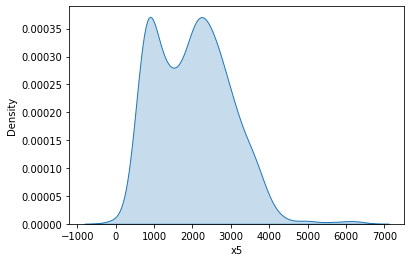

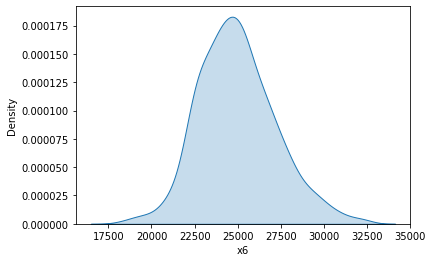

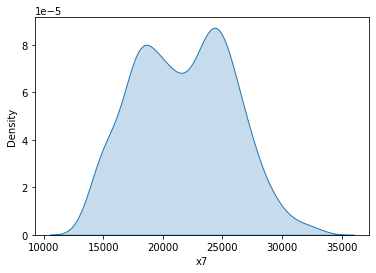

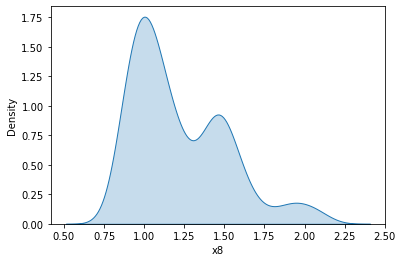

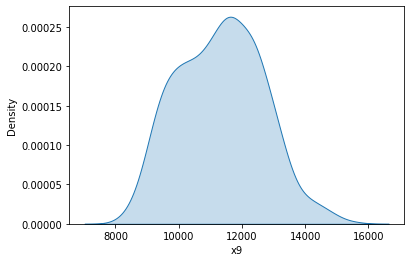

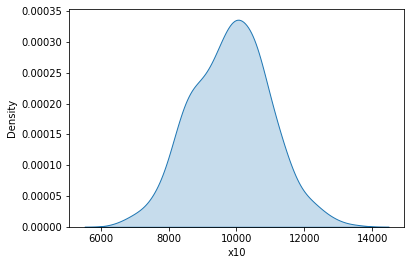

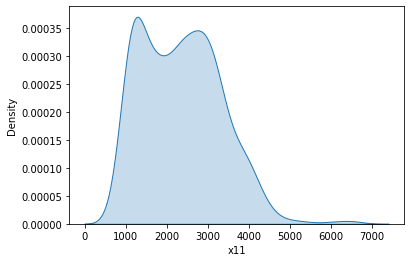

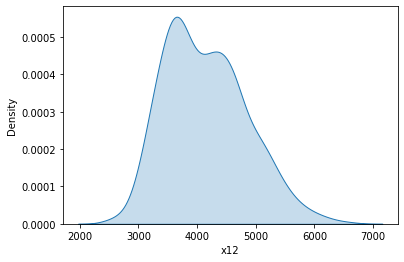

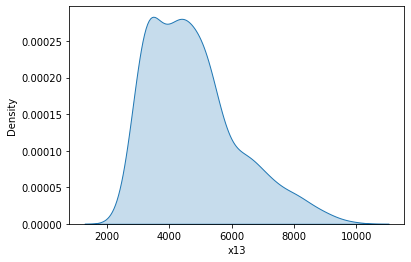

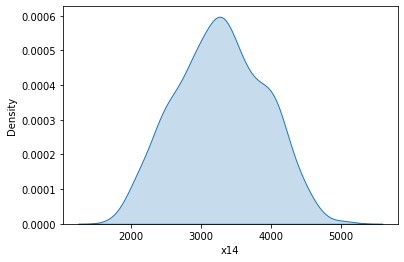

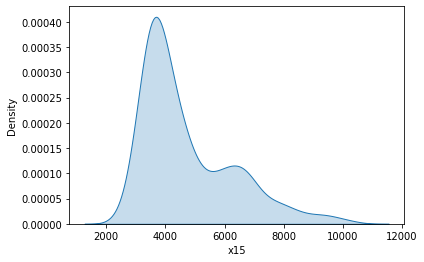

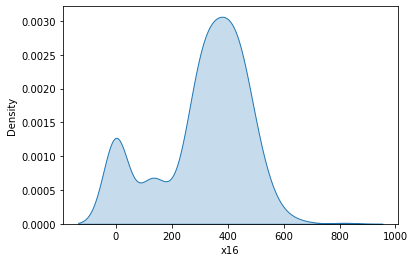

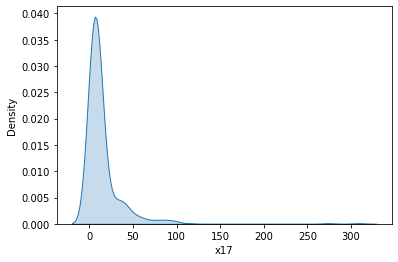

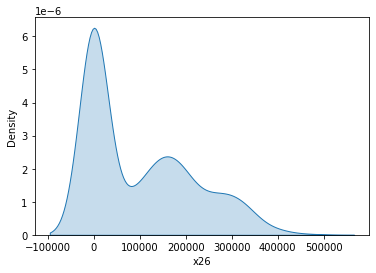

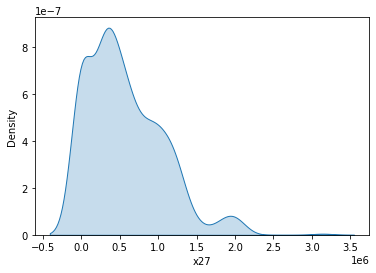

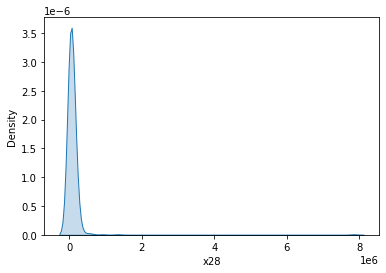

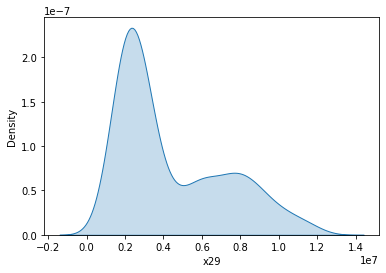

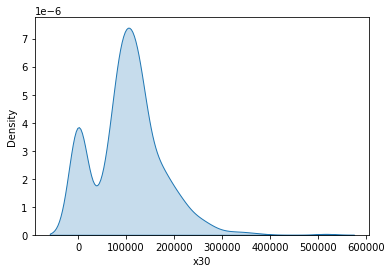

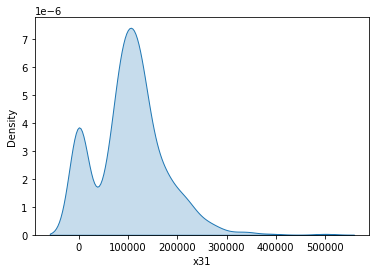

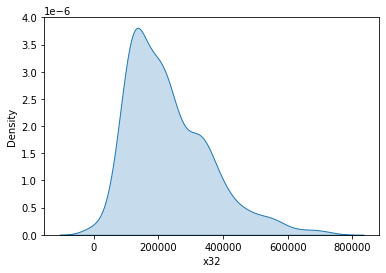

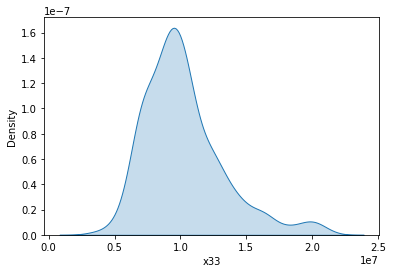

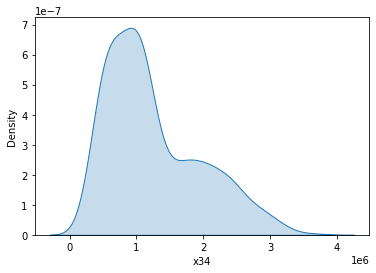

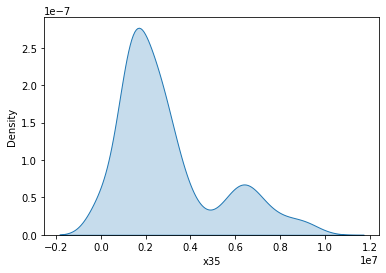

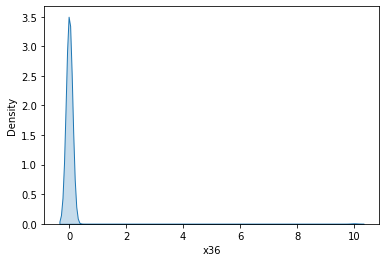

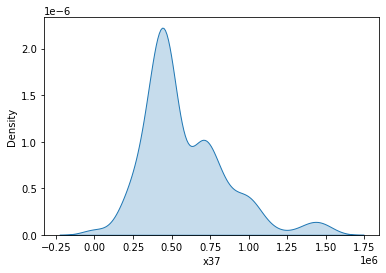

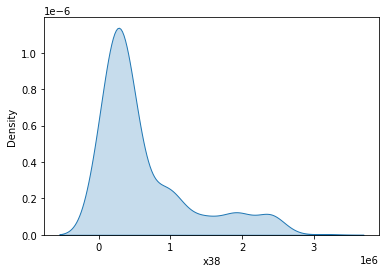

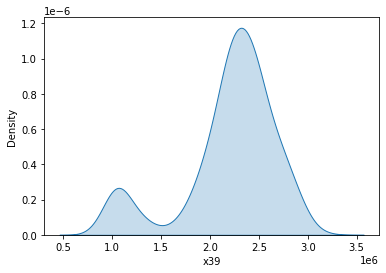

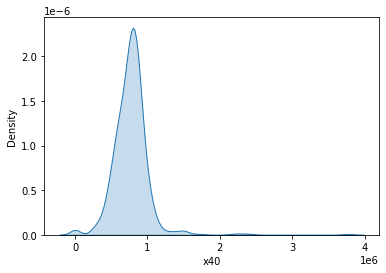

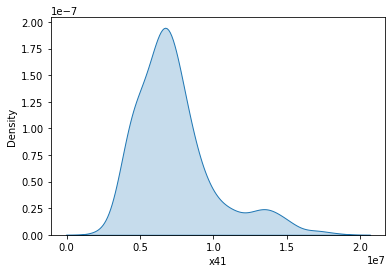

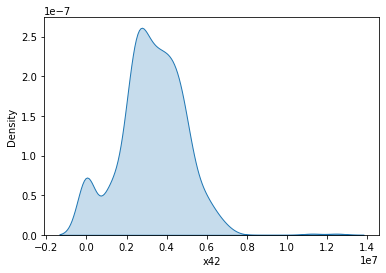

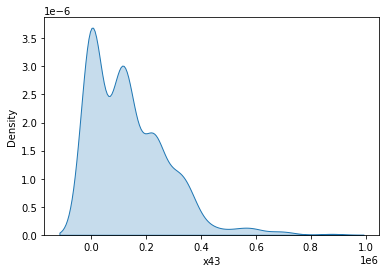

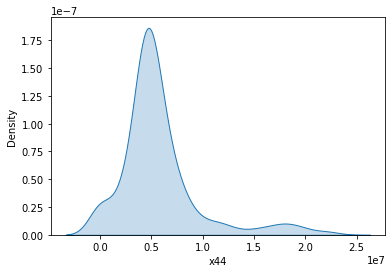

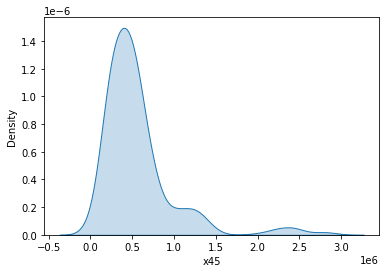

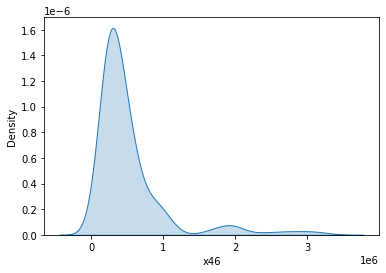

In [ ]:
for i in range(2,len(featureset_df.columns)):
  plt.figure()
  sns.kdeplot(featureset_df[featureset_df.columns[i]], label = featureset_df.columns[i], shade = True)

## 5) Feature Transformation

In [ ]:
#@title Input transformation type (ex: log, sqrt)
transformation = 'Square Root' #@param ["Square Root", "Mean","Log","Natural Log","None"]

In [ ]:
# These transformations stabilize large values in the dataset, and allow the data to be more normal
if transformation == "Square Root":
  X_transform = featureset_df.apply(np.sqrt)
elif transformation == "Mean":
  X_transform = featureset_df/featureset_df.mean()
elif transformation == "Natural Log": 
  featureset_df += 1 # natural log function is not defined at 0 so need to add 1 to each value 
  X_transform = featureset_df.apply(np.log)
else:
  X_transform = featureset_df

### 5.1) Feature Scaling

In [ ]:
'''
If you'd like to standardize your features, set the following parameter to "yes".
We have options for different scaling options: Min-Max Scaler or Standard Scaler.

If parameter is set to "No" or other value, no standardization will be performed.
'''


standardize_features = "Yes"

In [ ]:
if standardize_features == "No":
  featureset_df = X_transform
elif standardize_features == "Yes":
  #scaler = StandardScaler()
  scaler = MinMaxScaler()
  #standardized_transform = scaler.fit_transform(X_transform)
  standardized_transform = MinMaxScaler().fit_transform(X_transform)
  featureset_df = pd.DataFrame(standardized_transform, columns = X_transform.columns)
else:
  featureset_df = X_transform

In [ ]:
'''
Option to review visuals of the data. After the data is standardized the distributions
may take on a more normal shape.


for i in range(0,len(X_transform_stand.columns)):
  plt.figure()
  sns.kdeplot(X_transform_stand[X_transform_stand.columns[i]], label = X_transform_stand.columns[i], shade = True)
'''

In [ ]:
featureset_df.head()

,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46
0,0.71556,0.48402,0.68227,0.71226,0.54153,0.37630,0.48899,0.50590,0.54532,0.21536,0.76299,0.15683,0.66742,0.72711,0.37304,0.87324,0.33834,0.00000,0.24737,0.46451,0.46876,0.87389,0.68452,0.37422,0.35818,0.00000,0.54948,0.77426,0.71201,0.41235,0.46916,0.56303,0.00000,0.27209,0.91278,0.71936
1,1.00000,0.83469,0.74784,0.99180,0.99463,0.17316,0.74159,0.92437,0.66785,0.32645,0.93419,0.27374,0.99199,0.75835,0.36868,0.89422,0.54359,0.00000,0.18829,0.47058,0.48178,0.96884,0.68462,0.34698,0.33894,0.00000,0.55103,0.75708,0.72979,0.39465,0.59907,0.54563,0.00000,0.31188,0.98093,0.87675
2,0.88438,0.60766,0.66734,0.77194,0.80153,0.20177,0.51542,0.68342,0.53818,0.23135,0.78239,0.22268,0.93187,0.71697,0.52139,0.87164,0.52402,0.00000,0.22282,0.47359,0.46275,0.76018,0.32578,0.41015,0.34844,0.00000,0.46398,0.68175,0.68754,0.39290,0.52016,0.46265,0.00000,0.29406,0.87586,0.75203
3,0.74163,0.46213,0.70029,0.69711,0.60166,0.34723,0.50216,0.43793,0.55027,0.13419,0.73284,0.12042,0.72704,0.71782,0.50242,0.81122,0.50405,0.00000,0.15231,0.48786,0.46565,0.74356,0.33026,0.43076,0.39147,0.00000,0.45872,0.76627,0.19630,0.36003,0.44203,0.43723,0.00000,0.31029,0.89146,0.73121
4,0.92744,0.70085,0.68332,0.91132,0.79552,0.31174,0.79951,0.56154,0.57790,0.19228,1.00000,0.13873,0.81414,0.72711,0.53366,0.92894,0.48125,0.00000,0.20061,0.47797,0.47453,0.71401,0.39482,0.36319,0.39172,0.00000,0.44526,0.79924,0.76372,0.38380,0.45698,0.47765,0.00000,0.29382,0.91105,0.72985


## 6) Handle Multicollinearity (reduce feature set)

In [ ]:
'''
Note: A max of 50 features is recommended for 24 months of data due to risk of overfitting. 

Run correlation analysis and output positive/negative coefficients above specified
threshold. Look at highly correlated variables and drop

Run variance inflation factor analysis and output results to flag multicollinearity
above specified threshold
'''

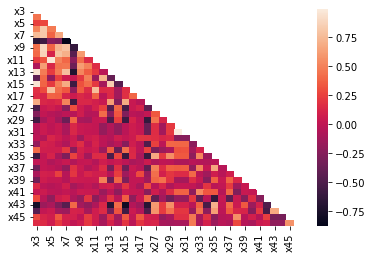

In [ ]:
'''
Print a correlation heatmap to visualize correlation across feature set
'''

correl = featureset_df.corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(correl)

# using the upper triangle matrix as mask 
sns.heatmap(correl, mask=matrix)

In [ ]:
#Input correlation threshold for output (must be between 0 and 1)

THRESHOLD_1 =  .6

In [ ]:
# output correlations > threshold_1 to review for data reduction

corrs_pos = correl.where(np.triu(np.ones(correl.shape)).astype(np.bool)) # zeros out lower triangle of matrix
corrs_pos = corrs_pos[corrs_pos > THRESHOLD_1].stack().reset_index() # user defines threshold and can increase to be more conservative
corrs_pos = corrs_pos.loc[corrs_pos[0]<1.0]
corrs_pos

,level_0,level_1,0
1,x3,x7,0.76131
2,x3,x13,0.95126
3,x3,x15,0.95704
4,x3,x26,0.68252
6,x4,x6,0.83583
7,x4,x7,0.82796
8,x4,x9,0.90227
9,x4,x10,0.87907
10,x4,x12,0.62921
12,x5,x11,0.97375


In [ ]:
corrs_pos.level_0.value_counts()

x4     5
x7     4
x3     4
x35    3
x6     3
x27    2
x9     2
x5     2
x13    2
x15    1
x11    1
x30    1
x12    1
x43    1
Name: level_0, dtype: int64

In [ ]:
corrs_pos.level_1.value_counts()

x10    4
x15    3
x7     3
x9     3
x26    3
x44    2
x43    2
x16    2
x12    2
x13    2
x35    1
x14    1
x37    1
x6     1
x11    1
x31    1
Name: level_1, dtype: int64

In [ ]:
#Input 2nd correlation threshold (must be between -1 and 0)
THRESHOLD_2 =  -.6 #@param {type: "number"}

In [ ]:
# feature reduction 1B: output correlations < threshold_2 to review for data reduction 
corrs_neg = correl.where(np.triu(np.ones(correl.shape)).astype(np.bool)) # zeros out lower triangle of matrix
corrs_neg = corrs_neg[corrs_neg < THRESHOLD_2].stack().reset_index() # user defines threshold and can decrease to be more conservative
corrs_neg = corrs_neg.loc[corrs_neg[0]<1.0]
corrs_neg

,level_0,level_1,0
0,x3,x8,-0.66248
1,x3,x43,-0.76868
2,x7,x8,-0.87802
3,x8,x9,-0.60910
4,x8,x13,-0.71169
5,x13,x43,-0.67930
6,x15,x35,-0.60462
7,x15,x43,-0.80357
8,x26,x29,-0.61935
9,x26,x43,-0.68579


In [ ]:
corrs_neg.level_0.value_counts()

x3     2
x8     2
x15    2
x26    2
x13    1
x35    1
x7     1
Name: level_0, dtype: int64

In [ ]:
corrs_neg.level_1.value_counts()

x43    4
x8     2
x42    1
x13    1
x35    1
x9     1
x29    1
Name: level_1, dtype: int64

In [ ]:
'''
drop highly correlated columns after manual review of above output
'''
featureset_df.drop(columns = ['x3','x4','x5','x6','x7','x31'], inplace = True)

In [ ]:
featureset_df.columns

Index(['x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17',
       'x26', 'x27', 'x28', 'x29', 'x30', 'x32', 'x33', 'x34', 'x35', 'x36',
       'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46'],
      dtype='object')

In [ ]:
featureset_df.drop(columns = ['x13','x15','x17','x36'], inplace = True)

In [ ]:
'''
Run VIF analysis and flag values greater than 7
Industry best practice flags values above 10 as a violation of regression model 
assumptions
'''

vif = add_constant(featureset_df)

# loop to calculate the VIF for each X 
vif = pd.Series([variance_inflation_factor(vif.values, i) 
      for i in range(vif.shape[1])], 
      index=vif.columns) 
print(vif.sort_values(ascending=False))

const   210.80676
x14     10.73290 
x12     9.50067  
x43     6.77819  
x9      6.09066  
x35     6.04611  
x10     5.97034  
x26     4.82088  
x27     3.93889  
x44     3.79662  
x45     3.49348  
x8      3.42035  
x11     3.29364  
x32     3.07897  
x38     3.05117  
x39     2.88879  
x16     2.88586  
x37     2.77228  
x29     2.69330  
x34     2.61931  
x42     2.59792  
x41     2.51498  
x30     2.41116  
x33     2.32925  
x46     2.20992  
x28     1.67995  
x40     1.66637  
dtype: float64


### 6.1) Additional data reduction

In [ ]:
'''
If there are still too many features, one can run a regression, analyze
the significant predictors using p-value analysis and remove any
insignificant features.
'''

In [ ]:
'''

# add column of 1's to estimate intercept parameter
featureset_df = sm.add_constant(featureset_df) 

# define Y
Y = df[[kpi_col]]
X = featureset_df
# run OLS model using statsmodels package for p-values
model = sm.OLS(Y, X)
results = model.fit()
predictions = model.predict(results.params) 

print_model = results.summary()
print_model
'''

In [ ]:
'''
Set a p-value threshold. This removes features with p-values greater than the threshold.

# Input p-Value threshold
p_threshold =  .1 #@param {type: "number"}

# FINAL feature selection/data reduction
results_df = (results.summary2().tables[1])
sig_input = list(results_df[results_df['P>|t|']<=P_THRESHOLD].index)[1:]
X_inputs = df[sig_input] 
X_inputs.columns

'''

In [ ]:
'''
If there are still too many features, one can run K-Best analysis.
This selects top features based on univariate testing

k_best = SelectKBest(f_regression, k=len(X_inputs.columns))
k_best.fit_transform(X_inputs, Y)
'''

In [ ]:
'''
If there are still too many features, one can run recursive feature elimination (RFE),
which ranks features based on recursive model testing

lm = LinearRegression()
rfe = RFE(lm, 1)
X_rfe = rfe.fit_transform(X_inputs,Y)
lm.fit(X_rfe,Y)
'''

In [ ]:
'''
Output results of optional feature selection process

# create dataframe with KBest and RFE results
opt_datared_df = pd.DataFrame({'feature': X_inputs.columns, 'p_value': k_best.pvalues_, 'rfe_rank': rfe.ranking_}).sort_values('p_value')
opt_datared_df
'''

In [ ]:
'''
# Input p-Value and rank thresholds for optional data reduction
#P_THRESHOLD_OPT =  .1 #@param {type: "number"}
#RANK_THRESHOLD =  1 #@param {type: "number"}

# OPTIONAL feature selection/data reduction

#opt_reduction = opt_datared_df[((opt_datared_df['p_value']<=P_THRESHOLD_OPT) | 
                             #(opt_datared_df['rfe_rank'] <= RANK_THRESHOLD))] 

# create list of FINAL model inputs, overwriting previous input feature list.
#opt_inputs =[]   

#for index, rows in opt_reduction.iterrows(): # iterate over each row 
#    opt_inputs.append(rows.feature) 

#X_inputs = X_inputs[opt_inputs]                           
'''


## 7) Export Final Dataset

In [ ]:
final_df = featureset_df
final_df['y1'] = df['y1']
pandas_gbq.to_gbq(final_df, destination_table = 'RBA_demo.cleaned_data_', project_id='', if_exists = 'replace') #update project name

## 8) Additional Considerations

In [ ]:
'''
Time lags: does media on day 1 impact conversions on day 2 (and so on)

Diminishing returns: large increases in spend do not necessarily result in 1:1
increases in conversions

External factors: are there peak periods that should be accounted for? (i.e.
flags for promotions, creatives, price changes in market, etc.)

L1 regularization: a systematic way to remove insignificant inputs and prevents 
overfitting


The following code is in progress and still requires testing, but can be used
to add lag and decay features)
'''

In [ ]:
'''
After adding in lag, decay, etc. features will need to be re-examined for 
multicollinearity and potential feature reduction prior to modeling.
'''

'''
#This function creates the different combinations of Lag, Decay, and Curve
def Transformation(dataframe,x):
    lag = []
    for i in range(0, 5, 1):
        data = dataframe[x].shift(i).to_frame()
        data.columns = [col_name+'Lag'+str(i)for col_name in data.columns]
        # store DataFrame in list
        lag.append(data)
    # see pd.concat documentation for more info
    lag = pd.concat(lag,axis=1)
    lag=lag.fillna(0)
    Alpha = []
    for i in np.linspace(0.6,1.0,num=5):
        data = pow(lag,i)
        data.columns = [col_name+'Alpha'+str(i)for col_name in data.columns]
    # store DataFrame in list
        Alpha.append(data)
    # see pd.concat documentation for more info
    Alpha = pd.concat(Alpha,axis=1)  
    Decay=[]
    #j = 0
    for percent in np.linspace(0.6,1.0,5):
        data = Alpha.copy()
        data.columns = [col_name+'Decay'+str(percent)for col_name in data.columns]
        for i in range(0,len(Alpha)):
            for j in range(0,len(Alpha.columns)):
            #data = data + data.shift(1)*(1-i)
                if(i == 0):
                    data.iloc[i, j] = data.iloc[i, j]*percent
                else:
                    data.iloc[i, j] = data.iloc[i - 1, j] *(1-percent) + data.iloc[i,j] * percent
        Decay.append(data)
        j = j + 1
    Decay = pd.concat(Decay,axis=1)
    
    return Decay
'''